# 1. Basic Matrix Decomposition (LU, Cholesky, QR, and EVD)

Here, we perform some matrix factorization algorithms for a real nonsymmetric square matrix and a real symmetric square matrix.

## Setting

First, install `PyTorchDecomp`.

In [1]:
import subprocess
repo_url = "https://github.com/chiba-ai-med/PyTorchDecomp.git"
install_command = f"pip install git+{repo_url}"
subprocess.check_call(install_command, shell=True)

## Package Loading

Then, load the necessary packages for data analysis, including `PyTorchDecomp`.

In [2]:
import torch
import torchdecomp as td
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Asymmetric Square Matrix Decomposition

First, the LU and QR decompositions are performed on `PyTorch` as matrix decomposition algorithms for an asymmetric square matrix.

### Toy data

Prepare the following artificial toy data.
In order to visually inspect the patterns in the data detected by each matrix decomposition algorithm, four blocks with larger values than the other elements are placed as shown below.

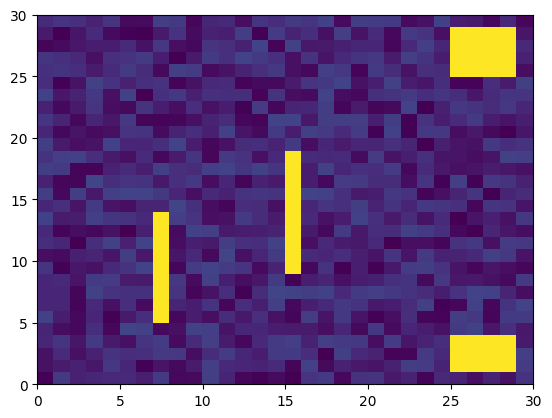

In [3]:
torch.manual_seed(123456)
asym_mat = torch.rand(30, 30, dtype=torch.float64)
asym_mat[5:14, 7] = 5
asym_mat[1:4, 25:29] = 5
asym_mat[9:19, 15:16] = 5
asym_mat[25:29, 25:29] = 5
fig, ax = plt.subplots()
ax.pcolor(asym_mat)
plt.show()

### LU Decomposition

In the LU decomposition, the asymmetric square matrix $X$ ($n \times n$) is decomposed as the product of two factor matrices $L$ and $U$ as follows.

$$
X = LU
$$

, where $L$ is an $n \times n$ lower triangular matrix and $U$ is an $n \times n$ upper triangular matrix, and only $L$ has all diagonal elements 1. LU decomposition is often used as a pre-processing step to make problems easier to solve, such as solving simultaneous equations or raandomized SVD, by utilizing the properties of triangular matrices such as $L$ and $U$.

To realize this matrix decomposition, we first prepare $L$ and $U$ in `td.LULayer`, define the loss terms (`lower_tri_loss`, `upper_tri_loss`) to force the upper triangular part of $L$ and the lower triangular part of $U$ to take zero values as follows, and added to the matrix reconstruction error term in a weighted manner.

In [4]:
# Instantiation of LULayer
lu_layer = td.LULayer(asym_mat)

# Optimizer
optimizer = optim.SGD(lu_layer.parameters(), lr=0.01)

# Weight for each objective function
weights_lu = np.array([1, 2])
weights_lu = weights_lu / sum(weights_lu)

# Iteration
loss_array_lu = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = lu_layer()
    # Loss
    lower_tri_loss = torch.norm(lu_layer.L - torch.tril(lu_layer.L, diagonal=-1))
    upper_tri_loss = torch.norm(lu_layer.U - torch.triu(lu_layer.U, diagonal=1))
    loss = weights_lu[0] * torch.sum((asym_mat - x_pred)**2) + weights_lu[1] * (lower_tri_loss + upper_tri_loss)
    loss_array_lu.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Convergence Check

It is important to check the degree of loss reduction due to iterational calculations to see if the calculations are converging adequately. Especially in the gradient descent framework, the convergence is easily affected by the step size (`lu`) of `optim.SGD`, so if the values hardly change, are jagged, or even show an increase in loss, then tuning the step size parameter is essential. Tuning the weights parameter, which indicates which and how much loss to consider, is also equally important.

Here, the calculations appear to be well converged.

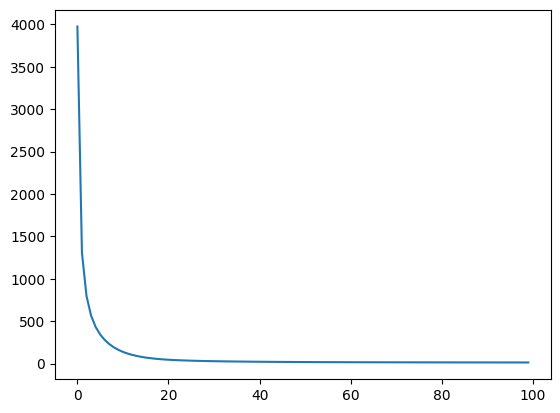

In [5]:
plt.plot(loss_array_lu)
plt.show()

#### Pattern Check

Below are heat maps of $L$ and $U$ and their matrix products obtained by the above LU decomposition. It can be seen that both $L$ and $U$ are lower and upper triangular matrix-like, respectively, and the matrix product $LU$ seems a good approximation of the original matrix $X$.

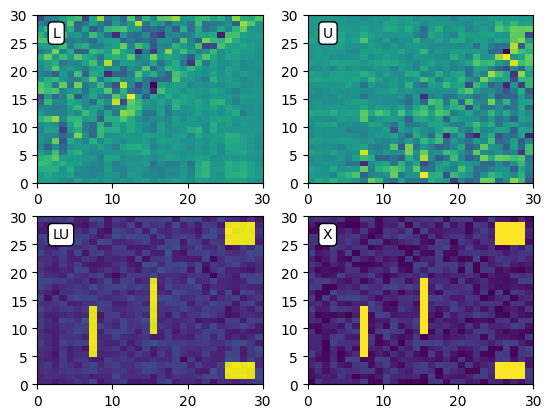

In [6]:
L = lu_layer.L.detach().numpy()
U = lu_layer.U.detach().numpy()
LU = L @ U
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.pcolor(L)
ax2.pcolor(U)
ax3.pcolor(LU)
ax4.pcolor(asym_mat)
ax1.annotate('L', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax2.annotate('U', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax3.annotate('LU', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax4.annotate('X', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
plt.show()

### QR Decomposition

In the QR decomposition, the asymmetric square matrix $X$ ($n \times n$) is decomposed as the product of two factor matrices $Q$ and $R$ as follows.

$$
X = QR
$$
, where $Q$ is an $n \times n$ orthogonal matrix ($Q^{T}Q=I$) and $R$ is an $n \times n$ upper triangular matrix. QR decomposition is often used as a pre-processing step to make problems easier to solve, such as generalized inverse matrix or rbandomized SVD, by utilizing the properties of orthogonal matrix $Q$.

As in the LU decomposition, the matrices $Q$ and $R$ are optimized iteratively as follows. Here, the error between $Q^{T}Q$ and $I$ is taken as loss (`ortho_loss`) to improve the orthogonality of $Q$. In addition, as with $U$ in the $LU$ decomposition, the lower triangular part of $R$ is taken as loss (`tri_loss`) to take zero values and added with the matrix reconstruction error with weights.

In [7]:
# Instantiation of LULayer
qr_layer = td.QRLayer(asym_mat)

# Optimizer
optimizer = optim.SGD(qr_layer.parameters(), lr=0.01)

# Weight for each objective function
weights_qr = np.array([3, 2, 1])
weights_qr = weights_qr / sum(weights_qr)

# Iteration
loss_array_qr = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = qr_layer()
    # Loss
    ortho_loss = torch.norm(torch.eye(qr_layer.Q.size(1)) - torch.mm(qr_layer.Q.t(), qr_layer.Q))
    upper_tri_loss = torch.norm(qr_layer.R - torch.triu(qr_layer.R))
    loss = weights_qr[0] * torch.sum((asym_mat - x_pred)**2) + weights_qr[1] * ortho_loss + weights_qr[2] * upper_tri_loss
    loss_array_qr.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Convergence Check

As in LU decomposition, the calculations appear to be well converged.

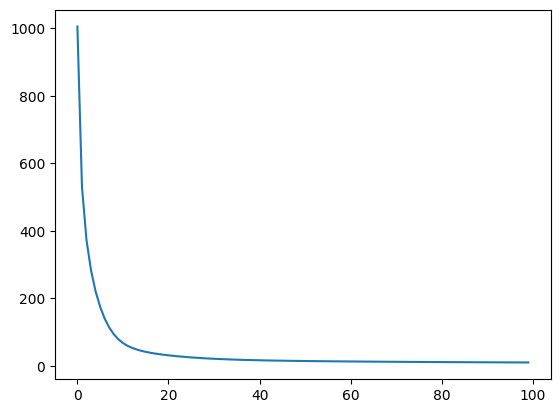

In [8]:
plt.plot(loss_array_qr)
plt.show()

#### Pattern Check

We can see that $Q$ is a orthogonal-like matrix because the diagonal elements of $Q^{T}Q$ are large in value. $R$ is upper triangular matrix-like. The matrix product $QR$ seems a good approximation of the original matrix $X$.

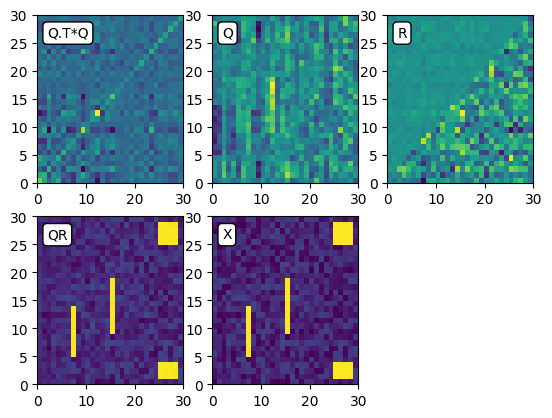

In [9]:
Q = qr_layer.Q.detach().numpy()
R = qr_layer.R.detach().numpy()
QR = Q @ R
fig = plt.figure()
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax1.pcolor(np.matmul(Q.T, Q))
ax2.pcolor(Q)
ax3.pcolor(R)
ax4.pcolor(QR)
ax5.pcolor(asym_mat)
ax1.annotate('Q.T*Q', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax2.annotate('Q', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax3.annotate('R', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax4.annotate('QR', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax5.annotate('X', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
plt.show()

## Symmetric Square Matrix Decomposition

Next, the Cholesky and eigenvalue decompositions are performed on `PyTorch`b as matrix decomposition algorithms for a symmetric square matrix.

### Toy Data

Prepare the following artificial toy data. In order to allow each matrix decomposition algorithm to visually check the patterns contained in the data, rectangular blocks are placed in three locations and cross patterns in two locations, as shown below.

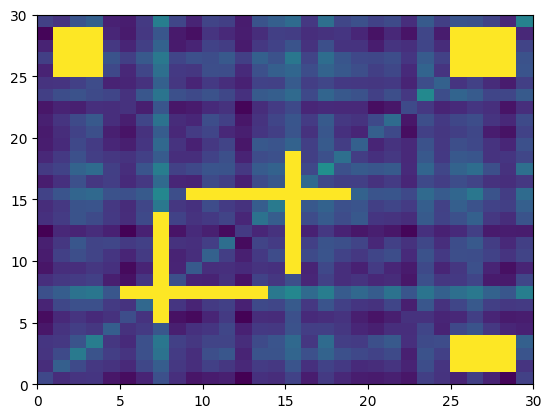

In [10]:
torch.manual_seed(123456)
sym_mat = torch.rand(30, 30, dtype=torch.float64)
sym_mat = torch.mm(sym_mat, sym_mat.t())
sym_mat[5:14, 7] = 20
sym_mat[7, 5:14] = 20

sym_mat[1:4, 25:29] = 20
sym_mat[25:29, 1:4] = 20

sym_mat[9:19, 15:16] = 20
sym_mat[15:16, 9:19] = 20

sym_mat[25:29, 25:29] = 20
sym_mat[25:29, 25:29] = 20

fig, ax = plt.subplots()
ax.pcolor(sym_mat)
plt.show()

### Cholesky Decomposition

The Cholesky decomposition is a special case of the LU decomposition when the input matrix $X$ is symmetric as follows:

$$
X = L^T L
$$

, where $L$ is an $n \times n$ lower triangular matrix and $L$ has all diagonal elements 1.

As with the LU decomposition, we define the loss (`cholesky_loss`) to the upper triangular part of $L$ taking non-zero values and add it to the matrix reconstruction error term between $X$ and $LL^{T}$ with weights.

In [11]:
# Instantiation of CholeskyLayer
cholesky_layer = td.CholeskyLayer(sym_mat)

# Optimizer
optimizer = optim.SGD(cholesky_layer.parameters(), lr=1e-3)

# Weight for each objective function
weights_cholesky = np.array([10, 1])
weights_cholesky = weights_cholesky / sum(weights_cholesky)

# Iteration
loss_array_cholesky = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = cholesky_layer()
    # Loss
    cholesky_loss = torch.norm(cholesky_layer.L - torch.tril(cholesky_layer.L))
    loss = weights_cholesky[0] * torch.sum((sym_mat - x_pred)**2) + weights_cholesky[1] * cholesky_loss
    loss_array_cholesky.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Convergence Check

The calculations appear to be well converged.

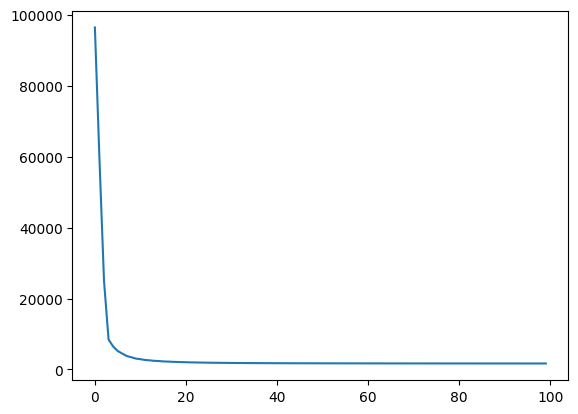

In [12]:
plt.plot(loss_array_cholesky)
plt.show()

#### Pattern Check

The matrix product $LL^{T}$ seems a good approximation of the original matrix $X$.

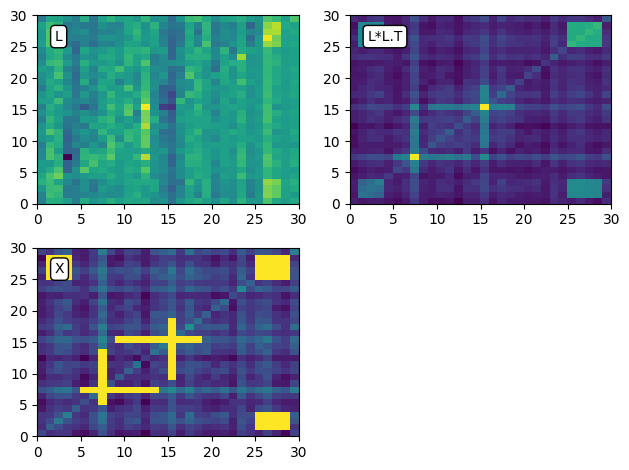

In [13]:
L = cholesky_layer.L.detach().numpy()
LL = L @ L.T
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax1.pcolor(L)
ax2.pcolor(LL)
ax3.pcolor(sym_mat)
ax1.annotate('L', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax2.annotate('L*L.T', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax3.annotate('X', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
plt.tight_layout()

### Eigenvalue Decomposition (EVD)

Finally, we perform eigenvalue decomposition (EVD).

EVD is a similar method to QR decomposition,

$$
X = Q \Lambda Q^{T}
$$

, where $Q$ is an $n \times n$ orthogonal matrix ($Q^{T}Q=I$) and $\Lambda$ is a $n \times n$ diagonal matrix. 

In [14]:
# Instantiation of SymRecLayer
n_components = 5
evd_layer = td.SymRecLayer(sym_mat, n_components)

# Optimizer
optimizer = optim.SGD(evd_layer.parameters(), lr=0.0005)

# Weight for each objective function
weights_evd = np.array([1, 2, 3])
weights_evd = weights_evd / sum(weights_evd)

# Iteration
loss_array_evd = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = evd_layer()
    # Loss
    ortho_loss_Q = torch.norm(torch.eye(evd_layer.Q.size(1)) - torch.mm(evd_layer.Q.t(), evd_layer.Q))
    diag_loss_Lambda = torch.norm(torch.eye(n_components) - evd_layer.Lambda)
    loss = weights_evd[0] * torch.sum((sym_mat - x_pred)**2) + weights_evd[1] * ortho_loss_Q + weights_evd[2] * diag_loss_Lambda
    loss_array_evd.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

The calculations appear to be well converged.

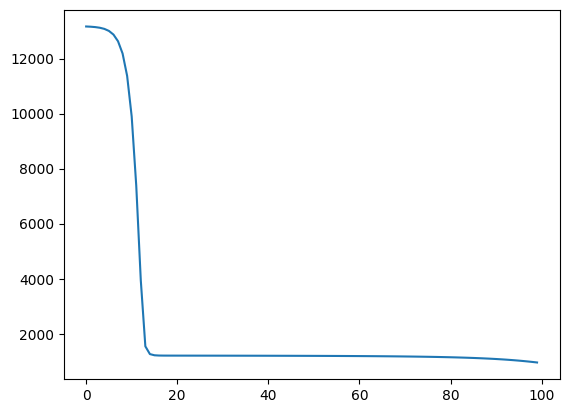

In [15]:
plt.plot(loss_array_evd)
plt.show()

### Patten Check

The matrix product $Q \Lambda Q^{T}$ seems a good approximation of the original matrix $X$.

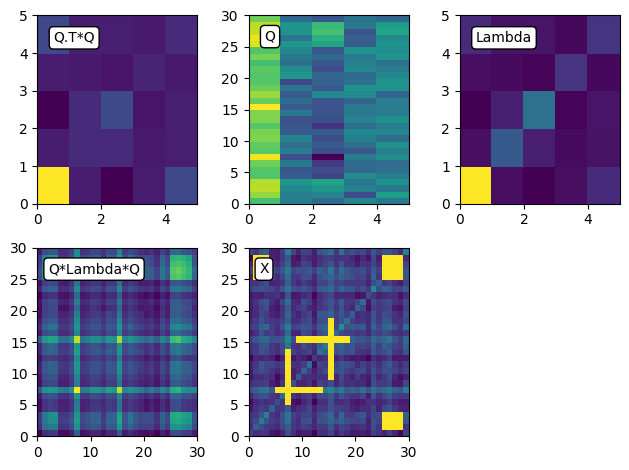

In [16]:
Q = evd_layer.Q.detach().numpy()
Lambda = evd_layer.Lambda.detach().numpy()
QLambdaQ = Q @ Lambda @ Q.T
fig = plt.figure()
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax1.pcolor(Q.T @ Q)
ax2.pcolor(Q)
ax3.pcolor(Lambda)
ax4.pcolor(QLambdaQ)
ax5.pcolor(sym_mat)
ax1.annotate('Q.T*Q', xy=(0.5,4.3), bbox=dict(boxstyle='round', fc='w'))
ax2.annotate('Q', xy=(0.5,26), bbox=dict(boxstyle='round', fc='w'))
ax3.annotate('Lambda', xy=(0.5,4.3), bbox=dict(boxstyle='round', fc='w'))
ax4.annotate('Q*Lambda*Q', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
ax5.annotate('X', xy=(2,26), bbox=dict(boxstyle='round', fc='w'))
plt.tight_layout()

## Reference

- **LU/QR/Cholesky/Eigenvalue Decomposition**
  - Gene H. Golub, Charles F. Van Loan Matrix Computations (Johns Hopkins Studies in the Mathematical Sciences)